### Links to Reference

[Keras Multi Output Model](https://github.com/rodrigobressan/keras-multi-output-model-utk-face/blob/master/notebook.ipynb)

[Keras Documentation - Functional API](https://keras.io/guides/functional_api/)

[Stack Overflow - How to Implement Multilabel Classification with UTKFace](https://stackoverflow.com/questions/66852823/how-to-implement-multilabel-classification-on-utkface-dataset-using-tensorflow-a)

[Tensorflow Guide - Keras Train and Evaluate](https://www.tensorflow.org/guide/keras/train_and_evaluate)

[Stack Overflow - Keras Value Error with Dimensions](https://stackoverflow.com/questions/61069068/keras-valueerror-dimensions-must-be-equal-but-are-6-and-9-for-node-equal)

[Helpful Guide for Age + Gender Detection Using DL](https://www.analyticsvidhya.com/blog/2021/07/age-and-gender-detection-using-deep-learning/)

[Keras Model Output Always Same Error](https://github.com/keras-team/keras/issues/6447)

### Imports

In [162]:
import os
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
import cv2

### Image Labels
The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

**age** is an integer from 0 to 116, indicating the age

**gender** is either 0 (male) or 1 (female)

**race** is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

**date&time** is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [163]:
dataset_dict = {
    'race_id': {
        0: 'White', 
        1: 'Black', 
        2: 'Asian', 
        3: 'Indian', 
        4: 'Others'
    },
    'gender_id': {
        0: 'Male',
        1: 'Female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

dataset_dict

{'race_id': {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'},
 'gender_id': {0: 'Male', 1: 'Female'},
 'gender_alias': {'Male': 0, 'Female': 1},
 'race_alias': {'White': 0, 'Black': 1, 'Asian': 2, 'Indian': 3, 'Others': 4}}

### Loading Data into Text and CSV Files

In [164]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['Age', 'Gender', 'Race', 'File']
    df = df.dropna()
    
    return df

In [165]:
def parse_dataset_raw(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_raw_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), int(gender), int(race)
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_raw_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['Age', 'Gender', 'Race', 'File']
    df = df.dropna()
    
    return df

In [166]:
dataset_path = "UTKFace"
df = parse_dataset(dataset_path)
df

,Age,Gender,Race,File
0,9.0,Female,Asian,UTKFace/9_1_2_20161219204347420.jpg.chip.jpg
1,36.0,Male,Black,UTKFace/36_0_1_20170117163203851.jpg.chip.jpg
2,86.0,Female,White,UTKFace/86_1_0_20170120225751953.jpg.chip.jpg
3,26.0,Female,White,UTKFace/26_1_0_20170116171048641.jpg.chip.jpg
4,1.0,Female,Asian,UTKFace/1_1_2_20161219154612988.jpg.chip.jpg
...,...,...,...,...
23703,35.0,Male,White,UTKFace/35_0_0_20170117155112202.jpg.chip.jpg
23704,52.0,Male,Indian,UTKFace/52_0_3_20170119200211340.jpg.chip.jpg
23705,26.0,Male,Black,UTKFace/26_0_1_20170116010114628.jpg.chip.jpg
23706,28.0,Male,Black,UTKFace/28_0_1_20170117015458481.jpg.chip.jpg


In [167]:
df_raw = parse_dataset_raw(dataset_path)
df_raw

,Age,Gender,Race,File
0,9.0,1.0,2.0,UTKFace/9_1_2_20161219204347420.jpg.chip.jpg
1,36.0,0.0,1.0,UTKFace/36_0_1_20170117163203851.jpg.chip.jpg
2,86.0,1.0,0.0,UTKFace/86_1_0_20170120225751953.jpg.chip.jpg
3,26.0,1.0,0.0,UTKFace/26_1_0_20170116171048641.jpg.chip.jpg
4,1.0,1.0,2.0,UTKFace/1_1_2_20161219154612988.jpg.chip.jpg
...,...,...,...,...
23703,35.0,0.0,0.0,UTKFace/35_0_0_20170117155112202.jpg.chip.jpg
23704,52.0,0.0,3.0,UTKFace/52_0_3_20170119200211340.jpg.chip.jpg
23705,26.0,0.0,1.0,UTKFace/26_0_1_20170116010114628.jpg.chip.jpg
23706,28.0,0.0,1.0,UTKFace/28_0_1_20170117015458481.jpg.chip.jpg


In [168]:
import plotly.graph_objects as go
from IPython.display import display, Image

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
        
    img = fig.to_image(format="png")
    display(Image(img))

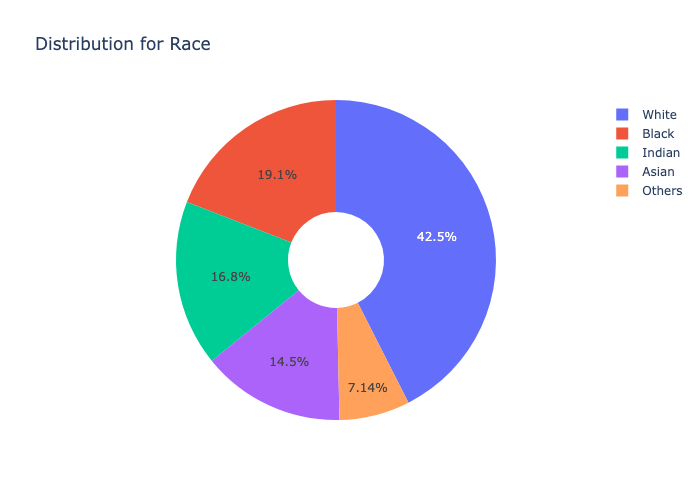

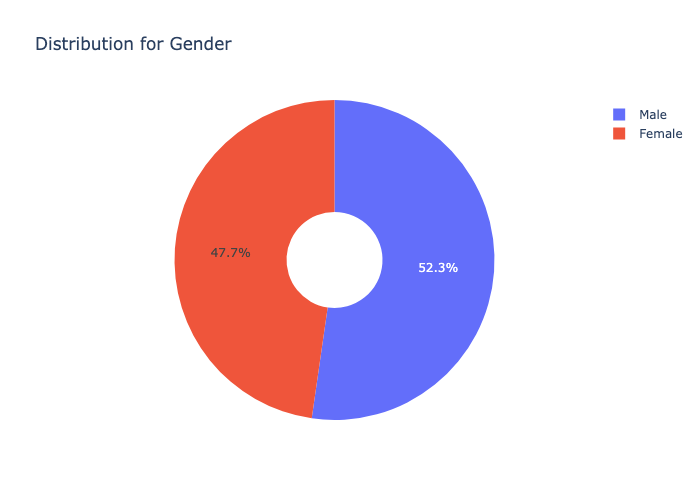

In [169]:
plot_distribution(df["Race"])
plot_distribution(df["Gender"])

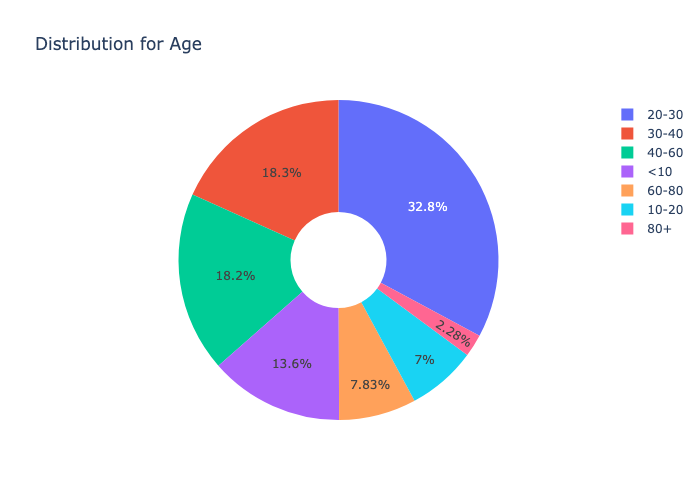

In [170]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']

age_binned = pd.cut(df['Age'], bins, labels=names)
plot_distribution(age_binned)


In [171]:
from tensorflow.keras.utils import to_categorical
TRAIN_TEST_SPLIT = 0.80
IM_WIDTH = 48
IM_HEIGHT = 48

class UtkFaceDataGenerator():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]

        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        self.df['gender_id'] = self.df['Gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        self.df['race_id'] = self.df['Race'].map(lambda race: dataset_dict['race_alias'][race])

        self.max_age = self.df['Age'].max()
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        image = cv2.imread(img_path)
        image = cv2.resize(image,(IM_HEIGHT, IM_WIDTH))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image) / 255.0
        
        return image
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        images, ages, races, genders = [], [], [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['Age']
                race = person['race_id']
                gender = person['gender_id']
                file = person['File']
                
                im = self.preprocess_image(file)
                
                ages.append(age / self.max_age)
                races.append(to_categorical(race, len(dataset_dict['race_id'])))
                genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                    images, ages, races, genders = [], [], [], []
                    
            if not is_training:
                break
                
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

In [172]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf

class UtkMultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        return x

    def build_race_branch(self, inputs, num_races):
        """
        Used to build the race branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_races)(x)
        x = Activation("softmax", name="race_output")(x)

        return x

    def build_gender_branch(self, inputs, num_genders=2):
        """
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)

        return x

    def build_age_branch(self, inputs):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.

        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)

        return x

    def assemble_full_model(self, width, height, num_races):
        """
        Used to assemble our multi-output model CNN.
        """
        input_shape = (height, width, 3)

        inputs = Input(shape=input_shape)

        age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs, num_races)
        gender_branch = self.build_gender_branch(inputs)

        model = Model(inputs=inputs,
                     outputs = [age_branch, race_branch, gender_branch],
                     name="face_net")

        return model
    
model = UtkMultiOutputModel().assemble_full_model(IM_HEIGHT, IM_WIDTH, num_races=len(dataset_dict['race_alias']))

In [173]:
model.summary()

Model: "face_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d_58 (Conv2D)             (None, 48, 48, 16)   448         ['input_10[0][0]']               
                                                                                                  
 conv2d_61 (Conv2D)             (None, 48, 48, 16)   448         ['input_10[0][0]']               
                                                                                                  
 conv2d_64 (Conv2D)             (None, 48, 48, 16)   448         ['input_10[0][0]']               
                                                                                           

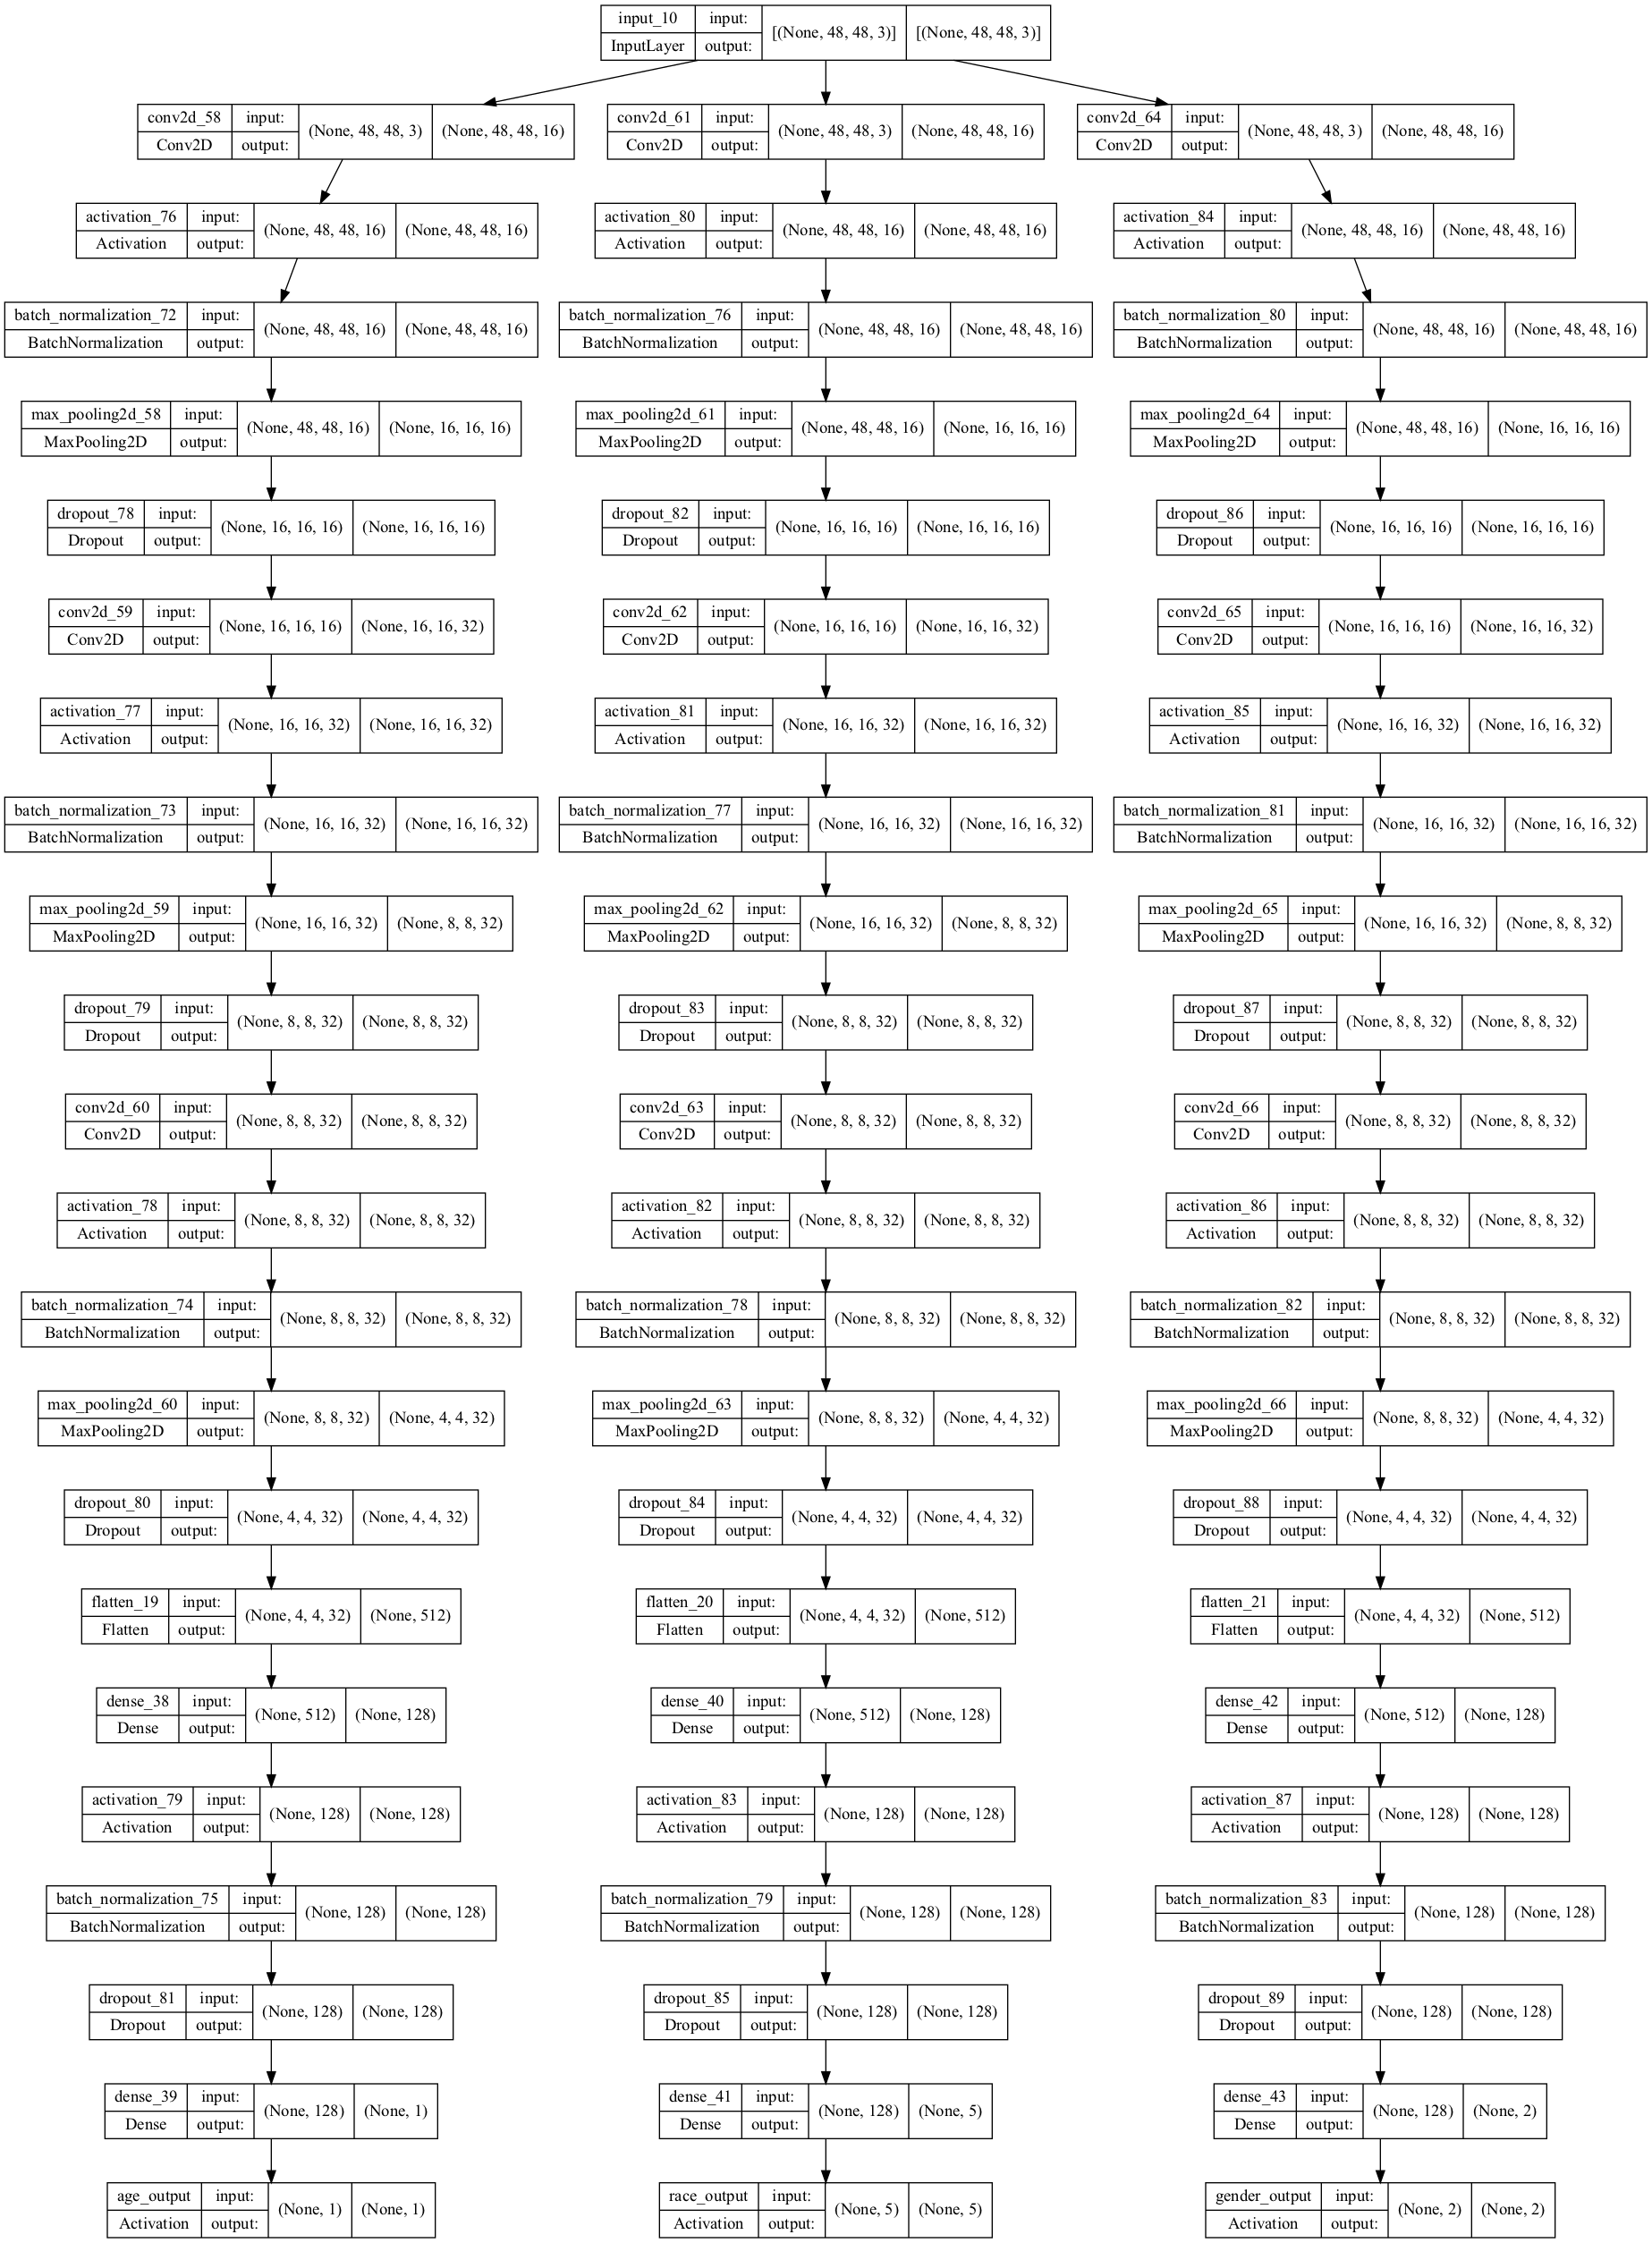

In [174]:
dot_img_file = 'model-images/new-model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [175]:
from tensorflow.keras.optimizers import Adam

init_lr = 1e-4
epochs = 100

opt = Adam(learning_rate=init_lr, decay=init_lr / epochs)

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse', 
                  'race_output': 'categorical_crossentropy', 
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 4., 
                  'race_output': 1.5, 
                  'gender_output': 0.1},
              metrics={
                  'age_output': 'mae', 
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})


In [176]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 32
valid_batch_size = 32
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)

callbacks = [ModelCheckpoint("./model_checkpoint", monitor='val_loss')]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)


Epoch 1/100


2022-06-08 22:20:46.167970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


474/474 [==============================] - ETA: 0s - loss: 9.6712 - age_output_loss: 1.6533 - race_output_loss: 1.9869 - gender_output_loss: 0.7759 - age_output_mae: 0.9941 - race_output_accuracy: 0.3215 - gender_output_accuracy: 0.6327

2022-06-08 22:21:04.807135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ./model_checkpoint/assets
474/474 [==============================] - 27s 52ms/step - loss: 9.6712 - age_output_loss: 1.6533 - race_output_loss: 1.9869 - gender_output_loss: 0.7759 - age_output_mae: 0.9941 - race_output_accuracy: 0.3215 - gender_output_accuracy: 0.6327 - val_loss: 11.4870 - val_age_output_loss: 2.1667 - val_race_output_loss: 1.8209 - val_gender_output_loss: 0.8897 - val_age_output_mae: 1.2174 - val_race_output_accuracy: 0.2741 - val_gender_output_accuracy: 0.5487
Epoch 2/100
474/474 [==============================] - 24s 50ms/step - loss: 5.5542 - age_output_loss: 0.7653 - race_output_loss: 1.6201 - gender_output_loss: 0.6302 - age_output_mae: 0.6818 - race_output_accuracy: 0.4167 - gender_output_accuracy: 0.7095 - val_loss: 2.7807 - val_age_output_loss: 0.1908 - val_race_output_loss: 1.3082 - val_gender_output_loss: 0.5527 - val_age_output_mae: 0.3133 - val_race_output_accuracy: 0.4934 - val_gender_output_accuracy: 0.7267
Epoch 3/100


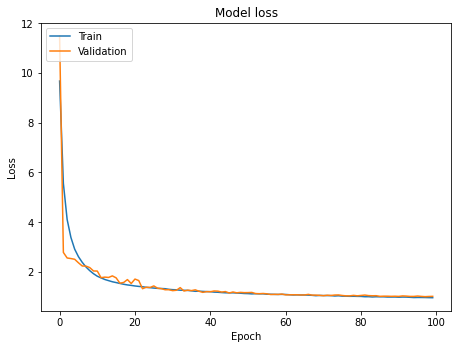

In [177]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

In [3]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['race_output_accuracy'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_race_output_accuracy'],
                    name='Valid'))


fig.update_layout(height=450, 
                  width=600,
                  title='Accuracy For Race Feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')

fig.write_html('acc_race.html', include_plotlyjs='cdn')

fig.show()


NameError: name 'history' is not defined

<Figure size 432x288 with 0 Axes>